In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import bin_time_data as bd
import query_database as qdb
import plot_lists
import load_Zidisha
import scipy.signal as sps

%matplotlib inline

In [2]:
sns.set()
sns.set_context('talk', font_scale=1.5)
sns.set_style('whitegrid')

In [3]:
# Connect to DB
zidisha_db = qdb.QueryDatabase('zidisha')

sql_dir = 'SQL_queries'

# List of all borrower countries
sql_query_file = 'country_name_list.sql'
df_countries = zidisha_db.source_query(sql_dir, sql_query_file, index_col_position=None)[0]
list_countries = df_countries.country_name.tolist()

# Big countries
list_countries = ['Burkina Faso', 'Ghana', 'Indonesia', 'Kenya']
labels_countries = ['All'] + list_countries

sql_query_short = lambda x: zidisha_db.source_query(sql_dir, x, where_filter_col='country_name', where_filter_list=list_countries)

# Accepted borrower account creation dates
list_df_new_borrowers = sql_query_short('borrowers_w_countries.sql')
for df in list_df_new_borrowers:
    df.insert(0, 'Number of new borrowers', range(len(df)))

# Borrower first loan creation dates
list_df_first_loans = sql_query_short('first_loans_w_countries.sql')
for df in list_df_first_loans:
    df.insert(0, 'Number of first loans', range(len(df)))

# Time to funding
list_df_time_to_fund = sql_query_short('time_to_funding.sql')
    
# Time to disbursement
list_df_time_to_disbursement = sql_query_short('time_to_disbursement.sql')
    
# All loans
list_df_all_loans = sql_query_short('all_loans.sql')

# Fully funded loans
list_df_fully_funded_loans = sql_query_short('fully_funded_loans.sql')

# Load exchange rates
list_df_exchange_start = sql_query_short('exchange_rates_start.sql')

# Invited loans
list_df_invited_loans = sql_query_short('invitee_new_loans.sql')

In [4]:
weeks_per_bin = 1
time_bins_edge = pd.date_range('2012-02-01','2015-09-01', None, str(weeks_per_bin)+'W')
time_bins_center = bd.bin_centers_from_edges_time(time_bins_edge)

bin_short = lambda list_df, bin_type_str, col_index=0: bd.bin_list_to_data_frame(bd.bin_list_time(time_bins_edge, list_df, bin_type=bin_type_str, col_to_bin=col_index, binned_col_labels=labels_countries))

df_all_loans_count = bin_short(list_df_all_loans, 'count')
df_fully_funded_count = bin_short(list_df_fully_funded_loans, 'count')
df_fund_rate = df_fully_funded_count.div(df_all_loans_count)

df_new_borrowers_count = bin_short(list_df_new_borrowers, 'count')
df_first_loans_count = bin_short(list_df_first_loans, 'count')
df_total_borrowers = bin_short(list_df_new_borrowers, 'mean')
df_total_first_loans = bin_short(list_df_first_loans, 'mean')

df_time_to_fund = bin_short(list_df_time_to_fund, 'median')
df_time_to_disbursement = bin_short(list_df_time_to_disbursement, 'median')

df_usd_requested = bin_short(list_df_all_loans, 'sum', 0)
df_raised_fraction = bin_short(list_df_all_loans, 'median', 1)
df_usd_inflow = bin_short(list_df_all_loans, 'sum', 2)
df_usd_secured = bin_short(list_df_all_loans, 'sum', 3)
df_secured_fraction = df_usd_secured / df_usd_requested

df_usd_requested_new = bin_short(list_df_first_loans, 'sum', 2)
df_raised_fraction_new = bin_short(list_df_first_loans, 'median', 3)
df_usd_inflow_new = bin_short(list_df_first_loans, 'sum', 4)
df_usd_secured_new = bin_short(list_df_first_loans, 'sum', 5)
df_secured_fraction_new = df_usd_secured_new / df_usd_requested_new

df_usd_requested_new_frac = df_usd_requested_new / df_usd_requested
df_usd_secured_new_frac = df_usd_secured_new / df_usd_secured

df_invitee_first_loan_count = bin_short(list_df_invited_loans, 'count')
df_invitee_first_loan_frac = df_invitee_first_loan_count / df_first_loans_count

# Policies
df_loan_loss_fee_kenya = load_Zidisha.loan_loss_reserve_fee_Kenya(time_bins_center)
df_loan_loss_fee_other = load_Zidisha.loan_loss_reserve_fee_Other(time_bins_center)
df_max_invites = load_Zidisha.max_invites(time_bins_center)
df_max_first_loan = load_Zidisha.max_new_loan_size(time_bins_center)
df_website_change = load_Zidisha.website_change(time_bins_center)
df_upfront_fee = load_Zidisha.upfront_fee(time_bins_center)


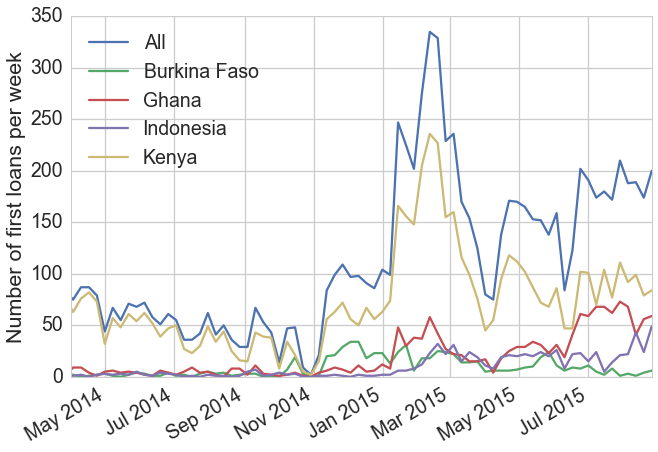

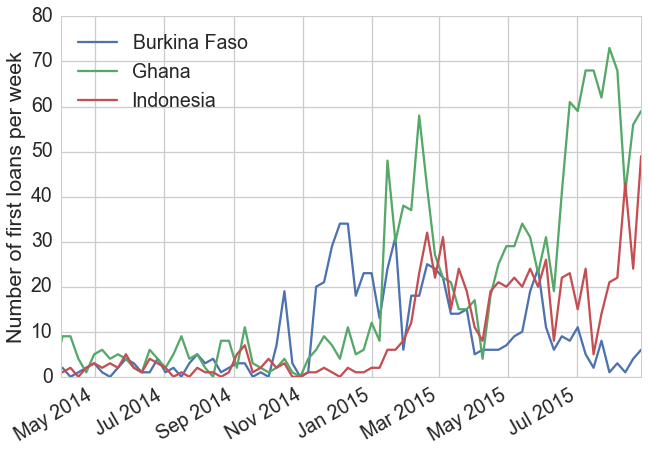

In [5]:
df_first_loans_count.plot()
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
plt.ylabel('Number of first loans per week')
df_first_loans_count[['Burkina Faso', 'Ghana', 'Indonesia']].plot()
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
plt.ylabel('Number of first loans per week')

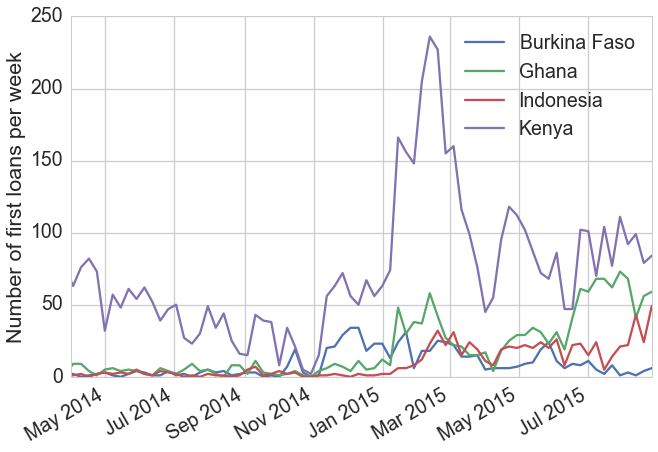

In [6]:
df_first_loans_count[['Burkina Faso', 'Ghana', 'Indonesia', 'Kenya']].plot()
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
plt.ylabel('Number of first loans per week')

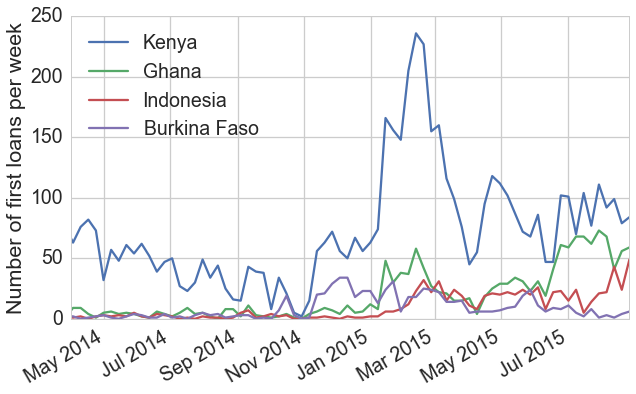

In [19]:
df_first_loans_count[['Kenya', 'Ghana', 'Indonesia', 'Burkina Faso']].plot(figsize=(10, 6))
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
plt.ylabel('Number of first loans per week')

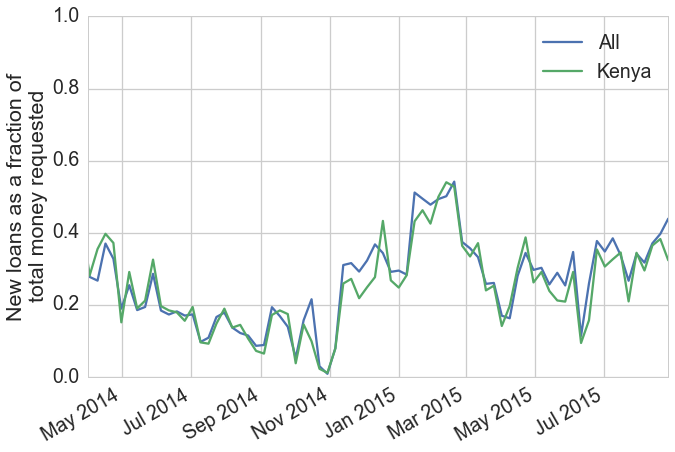

In [8]:
df_usd_requested_new_frac[['All', 'Kenya']].plot()
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
plt.ylabel('New loans as a fraction of\ntotal money requested')

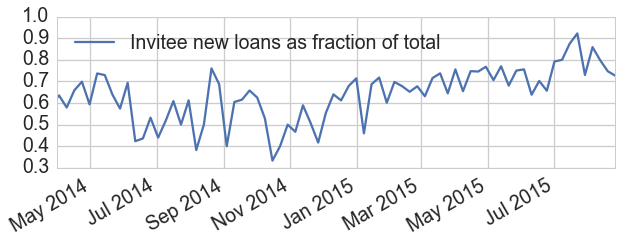

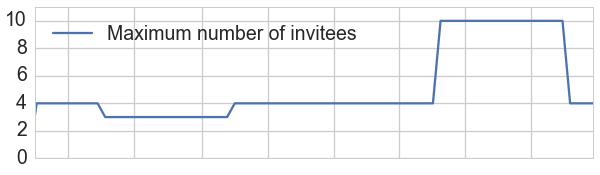

In [106]:
df_invitee_first_loan_frac[['Kenya']].plot(figsize=(10, 3))
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
plt.ylim([0.3, 1])
plt.legend(['Invitee new loans as fraction of total'], loc=2)

dfp = df_max_invites.plot(figsize=(10, 3))
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
plt.ylim([0,11])
dfp.axes.set_xticklabels([]);
plt.legend(['Maximum number of invitees'], loc=2)
#plt.ylabel('Maximum number\nof invitees')


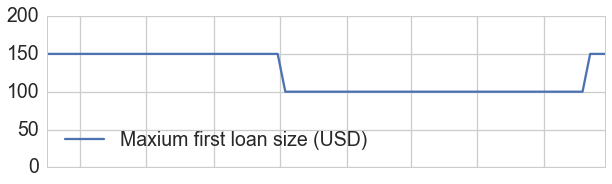

In [101]:
dfp = df_max_first_loan.plot(figsize=(10, 3))
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
#plt.ylabel('USD')
plt.ylim([0, 200])
plt.legend(['Maxium first loan size (USD)'], loc=3)
dfp.axes.set_xticklabels([]);

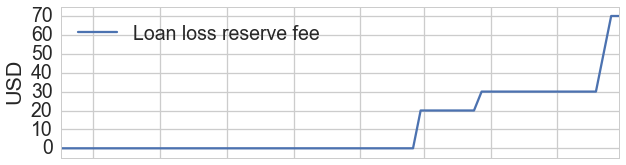

In [61]:
dfp = df_loan_loss_fee_kenya.plot(legend=False, figsize=(10, 3))
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
plt.legend(['Loan loss reserve fee'], loc=2)
plt.ylabel('USD')
plt.ylim([-5, 75]);
dfp.axes.set_xticklabels([]);

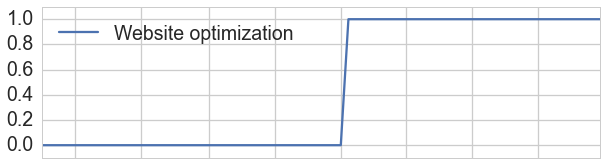

In [60]:
dfp = df_website_change.plot(legend=False, figsize=(10, 3))
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]]);
plt.legend(['Website optimization'], loc=2);
plt.ylim([-0.1,1.1]);
dfp.axes.set_xticklabels([]);

(735324.0, 735836.5)

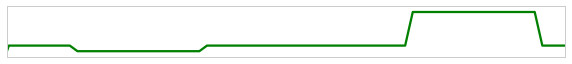

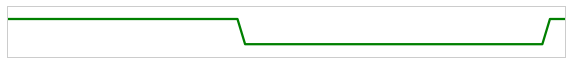

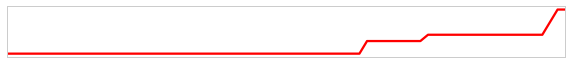

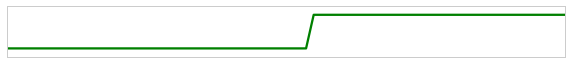

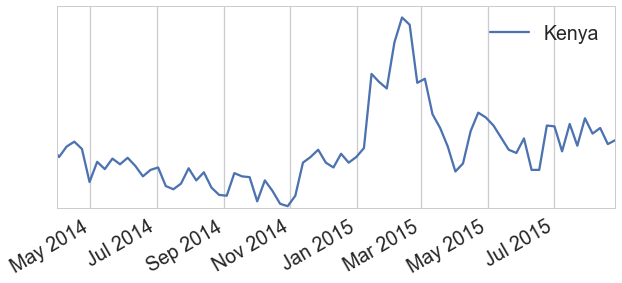

In [20]:
stack_fig_width = 10
stack_fig_height = 1

df_max_invites.plot(figsize=(stack_fig_width, stack_fig_height), xticks=[], yticks=[], grid=True, legend=False, style=['g'])
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
plt.ylim([2,11])
#plt.ylabel('Maximum number\nof invitees')

df_max_first_loan.plot(figsize=(stack_fig_width, stack_fig_height), xticks=[], yticks=[], grid=True, legend=False, style=['g'])
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
#plt.ylabel('Maxium first loan size (USD)')
plt.ylim([75, 175])

df_loan_loss_fee_kenya.plot(figsize=(stack_fig_width, stack_fig_height), xticks=[], yticks=[], grid=True, legend=False, style=['r'])
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
#plt.ylabel('Kenya loan loss reserve fee (USD)')
plt.ylim([-5, 75])

df_website_change.plot(figsize=(stack_fig_width, stack_fig_height), xticks=[], yticks=[], grid=True, legend=False, style=['g'])
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
plt.ylim([-.25,1.25])

df_first_loans_count[['Kenya']].plot(figsize=(stack_fig_width, 4*stack_fig_height), yticks=[])
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
#plt.ylabel('Number of first loans per week')

(735324.0, 735836.5)

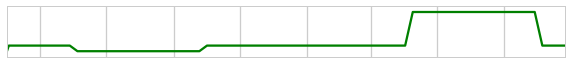

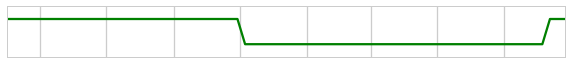

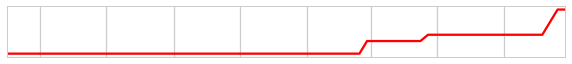

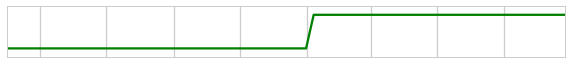

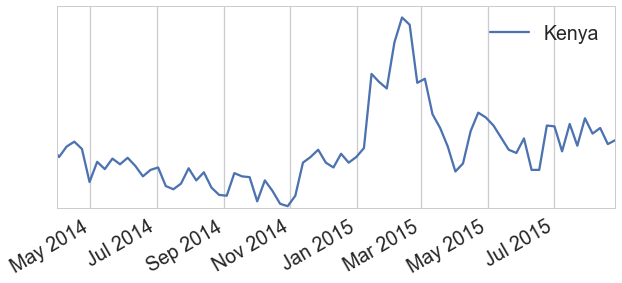

In [64]:
stack_fig_width = 10
stack_fig_height = 1

df_plot = df_max_invites.plot(figsize=(stack_fig_width, stack_fig_height), yticks=[], grid=True, legend=False, style=['g'])
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
plt.ylim([2,11])
df_plot.axes.set_xticklabels([]);
#plt.ylabel('Maximum number\nof invitees')

df_plot = df_max_first_loan.plot(figsize=(stack_fig_width, stack_fig_height), yticks=[], grid=True, legend=False, style=['g'])
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
#plt.ylabel('Maxium first loan size (USD)')
plt.ylim([75, 175])
df_plot.axes.set_xticklabels([]);

df_plot = df_loan_loss_fee_kenya.plot(figsize=(stack_fig_width, stack_fig_height), yticks=[], grid=True, legend=False, style=['r'])
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
#plt.ylabel('Kenya loan loss reserve fee (USD)')
plt.ylim([-5, 75])
df_plot.axes.set_xticklabels([]);

df_plot = df_website_change.plot(figsize=(stack_fig_width, stack_fig_height), yticks=[], grid=True, legend=False, style=['g'])
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
plt.ylim([-.25,1.25])
df_plot.axes.set_xticklabels([]);

df_first_loans_count[['Kenya']].plot(figsize=(stack_fig_width, 4*stack_fig_height), yticks=[])
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]]);
#plt.ylabel('Number of first loans per week')

(735324.0, 735836.5)

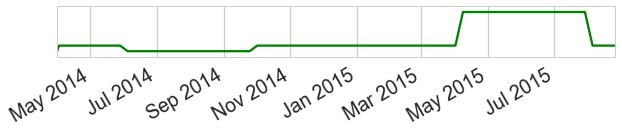

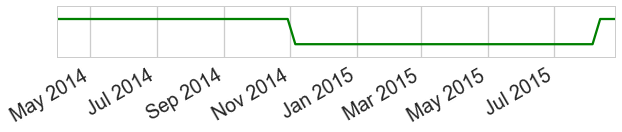

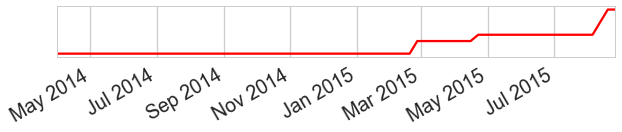

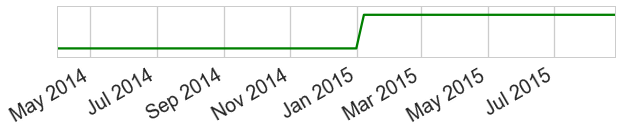

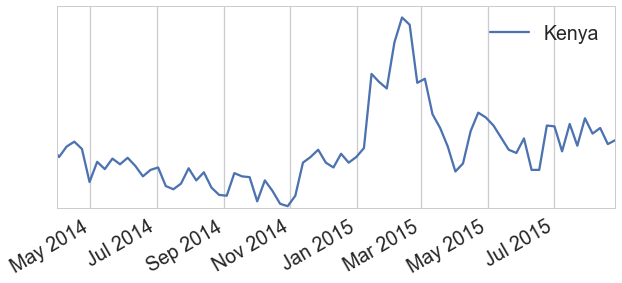

In [107]:
stack_fig_width = 10
stack_fig_height = 1

df_plot = df_max_invites.plot(figsize=(stack_fig_width, stack_fig_height), yticks=[], grid=True, legend=False, style=['g'])
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
plt.ylim([2,11])
#plt.ylabel('Maximum number\nof invitees')

df_plot = df_max_first_loan.plot(figsize=(stack_fig_width, stack_fig_height), yticks=[], grid=True, legend=False, style=['g'])
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
#plt.ylabel('Maxium first loan size (USD)')
plt.ylim([75, 175])

df_plot = df_loan_loss_fee_kenya.plot(figsize=(stack_fig_width, stack_fig_height), yticks=[], grid=True, legend=False, style=['r'])
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
#plt.ylabel('Kenya loan loss reserve fee (USD)')
plt.ylim([-5, 75])

df_plot = df_website_change.plot(figsize=(stack_fig_width, stack_fig_height), yticks=[], grid=True, legend=False, style=['g'])
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
plt.ylim([-.25,1.25])

df_first_loans_count[['Kenya']].plot(figsize=(stack_fig_width, 4*stack_fig_height), yticks=[])
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]]);
#plt.ylabel('Number of first loans per week')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     107.4
Date:                Tue, 29 Sep 2015   Prob (F-statistic):           3.35e-22
Time:                        14:54:26   Log-Likelihood:                -339.73
No. Observations:                  74   AIC:                             685.5
Df Residuals:                      71   BIC:                             692.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         44.4146      3.803     11.678      0.0

,0,1,2
0,1.000000e+00,9.218686e-16,-0.419766
1,9.218686e-16,1.000000e+00,-0.777738
2,-4.197665e-01,-7.777378e-01,1.000000


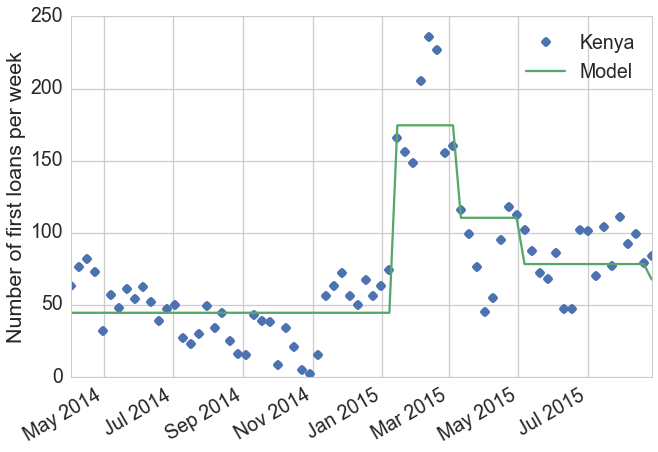

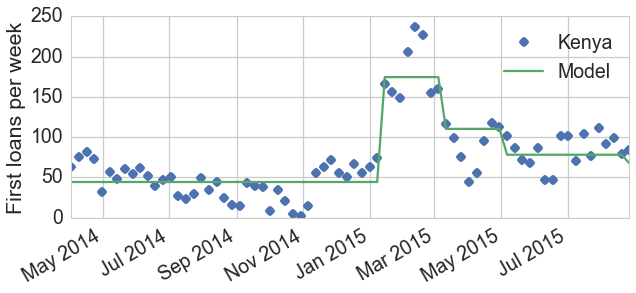

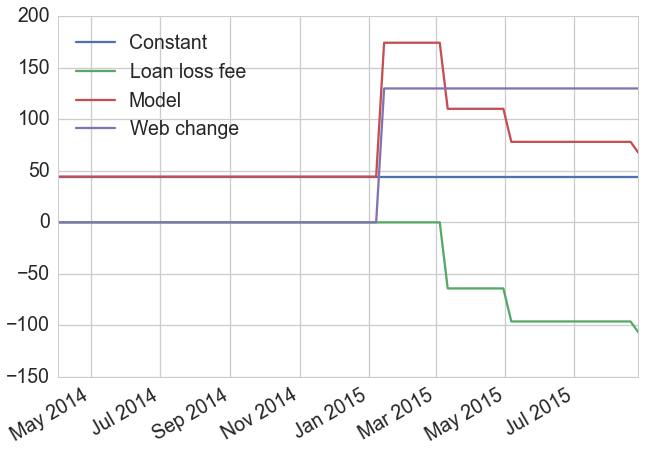

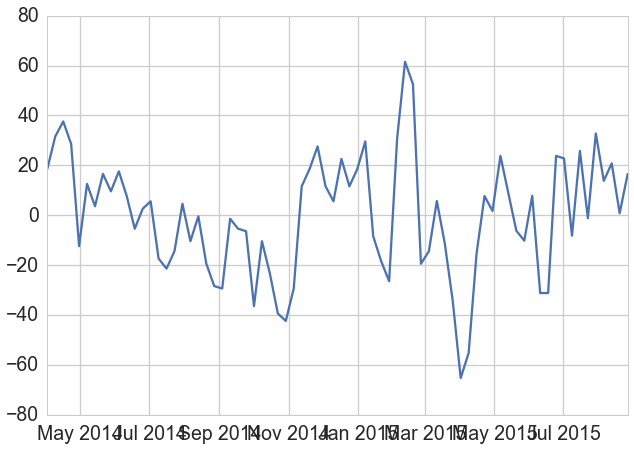

In [5]:
#Fit of Kenya

# Fit matrix, n_samples x n_features
#disperse_feature = df_avg_time_to_disperse.avg_time_to_disperse.values
#fund_time_feature = df_avg_time_to_fund.avg_time_to_fund.values
lag = round(2.0 / weeks_per_bin)
lag_comp = 0
fund_rate_feature = df_fund_rate.Kenya.values[lag_comp:-lag+lag_comp].copy()
lag_comp2 = 0
lag_end = -lag+lag_comp2
if lag_end:
    loan_loss_fee = df_loan_loss_fee_kenya.fee_level.values[lag_comp2:-lag+lag_comp2].copy()
    max_loan = df_max_first_loan.max_loan.values[lag_comp2:-lag+lag_comp2].copy()
else:
    loan_loss_fee = df_loan_loss_fee_kenya.fee_level.values[lag_comp2:].copy()
    max_loan = df_max_first_loan.max_loan.values[lag_comp2:].copy()
loan_loss_fee /= max_loan
lag_comp3 = round(1.0 / weeks_per_bin)
lag_end3 = -lag+lag_comp3
if lag_end3:
    web_change = df_website_change.web_change.values[lag_comp3:-lag+lag_comp3].copy()
else:
    web_change = df_website_change.web_change.values[lag_comp3:].copy()

invite_feature = df_total_borrowers.Kenya.values[:-lag].copy() * df_max_invites.max_invites.values[:-lag].copy()
max_loan_feature = df_max_first_loan.max_loan.values[:-lag].copy()

label_array = df_new_borrowers_count.Kenya.values[lag:].copy()
label_array = df_first_loans_count.Kenya.values[lag:].copy()
time_axis = time_bins_center[lag:].copy()

#fund_rate_feature = fund_rate_feature**4 # Sharpen funding rate feature, assumes borrowers are very sensitive

lag = 0
if lag:
    b, a = sps.iirfilter(1, (0, 1.0/(2*lag)))
    init_cond_out = np.zeros(len(a)-1)
    init_cond_in = np.zeros(len(b)-1)
    filt_init = sps.lfiltic(b, a, init_cond_out, x=init_cond_in)
    
    mean_offset = np.mean(invite_feature)
    invite_feature = sps.lfilter(b, a, invite_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(fund_rate_feature)
    fund_rate_feature = sps.lfilter(b, a, fund_rate_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(max_loan_feature)
    max_loan_feature = sps.lfilter(b, a, max_loan_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(loan_loss_fee)
    loan_loss_fee = sps.lfilter(b, a, loan_loss_fee-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(web_change)
    web_change = sps.lfilter(b, a, web_change-mean_offset, zi=filt_init)[0] + mean_offset


start_date = pd.datetime(2014,4,1)
for start_index in range(len(time_axis)):
    if time_axis[start_index] >= start_date:
        break
#start_index = 0
invite_feature = invite_feature[start_index:]
fund_rate_feature = fund_rate_feature[start_index:]
max_loan_feature = max_loan_feature[start_index:]
loan_loss_fee = loan_loss_fee[start_index:]
web_change = web_change[start_index:]

label_array = label_array[start_index:]
time_axis = time_axis[start_index:]

const_array = np.empty(len(label_array))
const_array.fill(1)
feature_mat = np.transpose(np.array([const_array, loan_loss_fee, web_change]))
#feature_mat = np.transpose(np.array([const_array, disperse_feature, fund_time_feature, invite_feature, fund_rate_feature, app_accept_feature, max_loan_feature]))
model = sm.OLS(label_array, feature_mat)
results = model.fit()
print(results.summary())
labels = ['x1: Loan loss fee', 'x2: website change']
#labels = ['x1: Time to dispersal','x2: Time to fund','x3: Max invites * total borrowers','x4: Fraction funded','x5: Fraction applicants accepted','x6: Maximum loan limit']
print('\n'.join(labels)+'\n')

#plt.scatter(time_axis, label_array)
#plt.plot(time_axis, results.predict())

df_fit1 = pd.DataFrame({'Kenya': label_array, 'Model': results.predict()}, index=time_axis)
df_fit1.plot(style=['o', '-'])
plt.ylabel('Number of first loans per week')
#plt.xlabel('Date')


stack_fig_width = 10
stack_fig_height = 1
df_fit2 = pd.DataFrame({'Kenya': label_array, 'Model': results.predict()}, index=time_axis)
df_fit2.plot(figsize=(stack_fig_width, 4*stack_fig_height), style=['o', '-'])
plt.ylabel('First loans per week')


#labels = ['const', 'Time to dispersal','Time to fund','Max invites * total borrowers','Fraction funded','Fraction applicants accepted','Maximum loan limit']
labels = ['Constant', 'Loan loss fee', 'Web change']
df_dict = {'Model': results.predict()}
for index in range(len(results.params)):
    df_dict[labels[index]] = feature_mat[:,index]*results.params[index]
df_fit = pd.DataFrame(df_dict, index=time_axis)
df_fit.plot()

kenya_nlr = label_array.copy()
#kenya_scaled = kenya_nlr.copy() * results.params[0]/results.params[2]
kenya_scaled = kenya_nlr.copy() / results.params[0]
kenya_fit_scaled = results.predict() / results.params[0]

plt.figure()
plt.plot(time_axis, results.resid)

kenya_norm_params = results.params / results.params[0]
kenya_norm_bse = results.bse / results.params[0]
print(kenya_norm_params)
print(kenya_norm_bse)

print(kenya_norm_params[2] + 2*np.sqrt(kenya_norm_bse[0]**2 + kenya_norm_bse[2]**2))

m_corr = results.cov_params()
v_sdev = np.sqrt(np.diag(m_corr))
m_corr /= np.outer(v_sdev, v_sdev)
pd.DataFrame(m_corr)



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     103.2
Date:                Mon, 28 Sep 2015   Prob (F-statistic):           9.81e-22
Time:                        10:06:58   Log-Likelihood:                -312.01
No. Observations:                  74   AIC:                             630.0
Df Residuals:                      71   BIC:                             636.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         13.9756      2.615      5.344      0.0

,0,1,2
0,1.000000e+00,1.571689e-15,-0.406355
1,1.571689e-15,1.000000e+00,-0.793550
2,-4.063546e-01,-7.935502e-01,1.000000


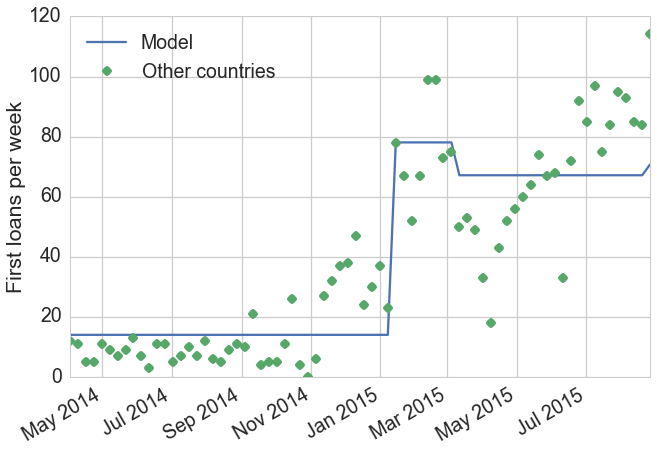

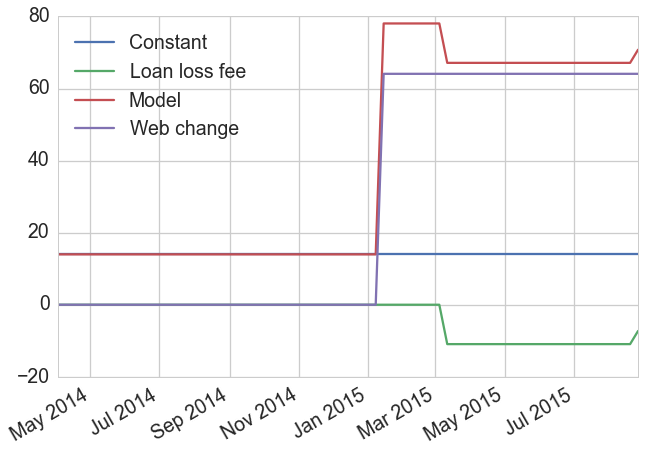

In [80]:
#Fit of other countries

# Fit matrix, n_samples x n_features
#disperse_feature = df_avg_time_to_disperse.avg_time_to_disperse.values
#fund_time_feature = df_avg_time_to_fund.avg_time_to_fund.values
lag = round(2.0 / weeks_per_bin)
lag_comp = 0
fund_rate_feature = df_fund_rate.Kenya.values[lag_comp:-lag+lag_comp].copy()
lag_comp2 = 0
lag_end = -lag+lag_comp2
if lag_end:
    loan_loss_fee = df_loan_loss_fee_other.fee_level.values[lag_comp2:-lag+lag_comp2].copy()
    max_loan = df_max_first_loan.max_loan.values[lag_comp2:-lag+lag_comp2].copy()
else:
    loan_loss_fee = df_loan_loss_fee_other.fee_level.values[lag_comp2:].copy()
    max_loan = df_max_first_loan.max_loan.values[lag_comp2:].copy()
loan_loss_fee /= max_loan
lag_comp3 = round(1.0 / weeks_per_bin)
lag_end3 = -lag+lag_comp3
if lag_end3:
    web_change = df_website_change.web_change.values[lag_comp3:-lag+lag_comp3].copy()
else:
    web_change = df_website_change.web_change.values[lag_comp3:].copy()

invite_feature = df_total_borrowers.Kenya.values[:-lag].copy() * df_max_invites.max_invites.values[:-lag].copy()
max_loan_feature = df_max_first_loan.max_loan.values[:-lag].copy()

label_array = df_first_loans_count.Indonesia.values[lag:].copy()
label_array += df_first_loans_count.Ghana.values[lag:].copy()
label_array += df_first_loans_count['Burkina Faso'].values[lag:].copy()
time_axis = time_bins_center[lag:].copy()

#fund_rate_feature = fund_rate_feature**4 # Sharpen funding rate feature, assumes borrowers are very sensitive

lag = 0
if lag:
    b, a = sps.iirfilter(1, (0, 1.0/(2*lag)))
    init_cond_out = np.zeros(len(a)-1)
    init_cond_in = np.zeros(len(b)-1)
    filt_init = sps.lfiltic(b, a, init_cond_out, x=init_cond_in)
    
    mean_offset = np.mean(invite_feature)
    invite_feature = sps.lfilter(b, a, invite_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(fund_rate_feature)
    fund_rate_feature = sps.lfilter(b, a, fund_rate_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(max_loan_feature)
    max_loan_feature = sps.lfilter(b, a, max_loan_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(loan_loss_fee)
    loan_loss_fee = sps.lfilter(b, a, loan_loss_fee-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(web_change)
    web_change = sps.lfilter(b, a, web_change-mean_offset, zi=filt_init)[0] + mean_offset


start_date = pd.datetime(2014,4,1)
for start_index in range(len(time_axis)):
    if time_axis[start_index] >= start_date:
        break
#start_index = 0
invite_feature = invite_feature[start_index:]
fund_rate_feature = fund_rate_feature[start_index:]
max_loan_feature = max_loan_feature[start_index:]
loan_loss_fee = loan_loss_fee[start_index:]
web_change = web_change[start_index:]

label_array = label_array[start_index:]
time_axis = time_axis[start_index:]

const_array = np.empty(len(label_array))
const_array.fill(1)
feature_mat = np.transpose(np.array([const_array, loan_loss_fee, web_change]))
#feature_mat = np.transpose(np.array([const_array, disperse_feature, fund_time_feature, invite_feature, fund_rate_feature, app_accept_feature, max_loan_feature]))
model = sm.OLS(label_array, feature_mat)
results = model.fit()
print(results.summary())
labels = ['x1: Loan loss fee', 'x2: website change']
#labels = ['x1: Time to dispersal','x2: Time to fund','x3: Max invites * total borrowers','x4: Fraction funded','x5: Fraction applicants accepted','x6: Maximum loan limit']
print('\n'.join(labels)+'\n')

#plt.scatter(time_axis, label_array)
#plt.plot(time_axis, results.predict())

df_fit1 = pd.DataFrame({'Other countries': label_array, 'Model': results.predict()}, index=time_axis)
df_fit1.plot(style=['-', 'o'])
plt.ylabel('First loans per week')
#plt.xlabel('Date')

#labels = ['const', 'Time to dispersal','Time to fund','Max invites * total borrowers','Fraction funded','Fraction applicants accepted','Maximum loan limit']
labels = ['Constant', 'Loan loss fee', 'Web change']
df_dict = {'Model': results.predict()}
for index in range(len(results.params)):
    df_dict[labels[index]] = feature_mat[:,index]*results.params[index]
df_fit = pd.DataFrame(df_dict, index=time_axis)
df_fit.plot()

other_nlr = label_array.copy()
#other_scaled = other_nlr.copy()# * results.params[0]/results.params[2]
other_scaled = other_nlr.copy() / results.params[0]
other_fit_scaled = results.predict() / results.params[0]

other_norm_params = results.params / results.params[0]
other_norm_bse = results.bse / results.params[0]
print(other_norm_params)
print(other_norm_bse)
print(other_norm_params[2] - 2*np.sqrt(other_norm_bse[0]**2 + other_norm_bse[2]**2))


m_corr = results.cov_params()
v_sdev = np.sqrt(np.diag(m_corr))
m_corr /= np.outer(v_sdev, v_sdev)
pd.DataFrame(m_corr)


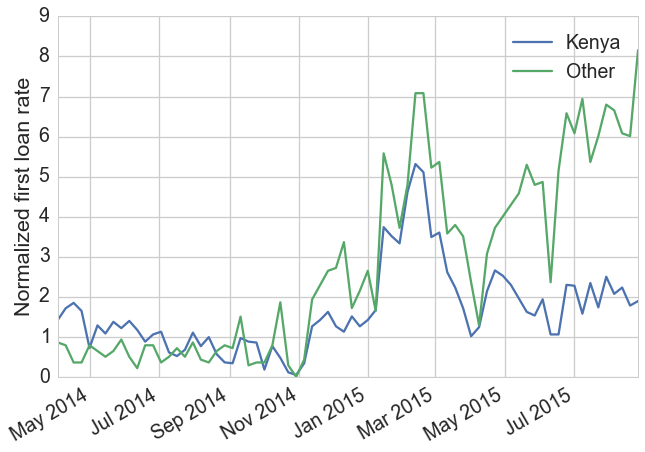

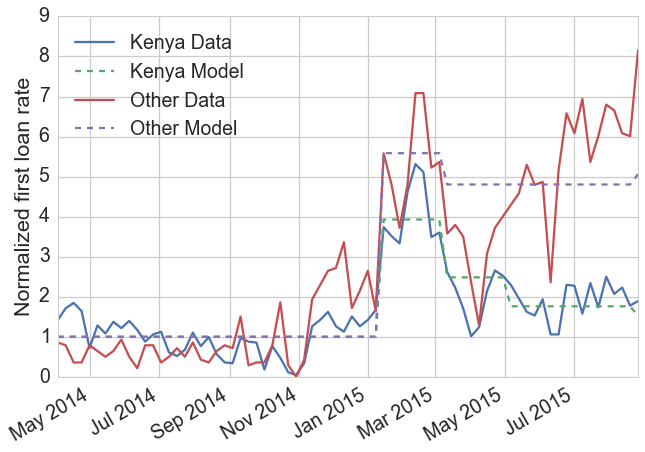

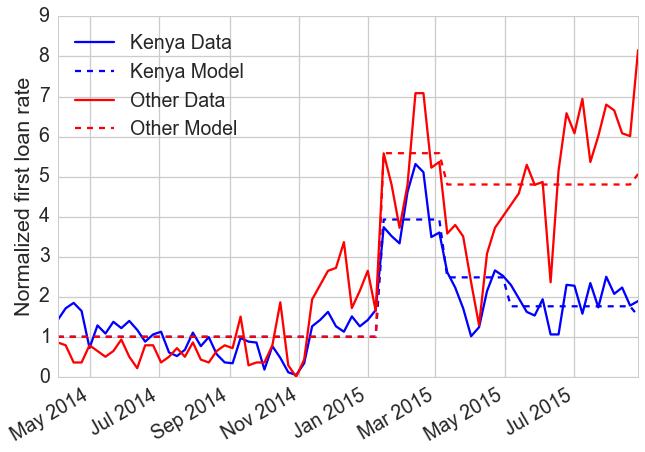

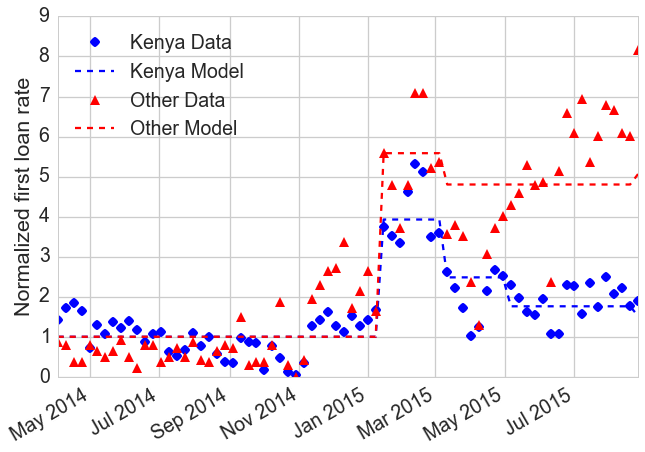

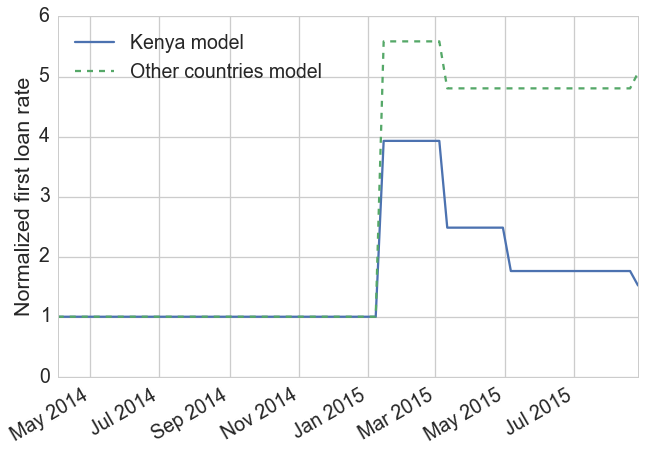

In [69]:
df_scaled = pd.DataFrame({'Kenya':kenya_scaled, 'Other':other_scaled}, index=time_axis)
df_scaled.plot()
plt.ylabel('Normalized first loan rate')

df_scaled = pd.DataFrame({'Kenya Data': kenya_scaled, 'Kenya Model': kenya_fit_scaled, 'Other Data': other_scaled, 'Other Model': other_fit_scaled}, index=time_axis)
fp = df_scaled.plot(style=['-','--','-','--'])
#plt.setp(fp, linestyle='--')
#plt.Line2D.set_linestyle('--')
plt.ylabel('Normalized first loan rate')

df_scaled = pd.DataFrame({'Kenya Data': kenya_scaled, 'Kenya Model': kenya_fit_scaled, 'Other Data': other_scaled, 'Other Model': other_fit_scaled}, index=time_axis)
fp = df_scaled.plot(style=['b-','b--','r-','r--'])
#plt.setp(fp, linestyle='--')
#plt.Line2D.set_linestyle('--')
plt.ylabel('Normalized first loan rate')

df_scaled = pd.DataFrame({'Kenya Data': kenya_scaled, 'Kenya Model': kenya_fit_scaled, 'Other Data': other_scaled, 'Other Model': other_fit_scaled}, index=time_axis)
fp = df_scaled.plot(style=['bo','b--','r^','r--'])
#plt.setp(fp, linestyle='--')
#plt.Line2D.set_linestyle('--')
plt.ylabel('Normalized first loan rate')

df_scaled = pd.DataFrame({'Kenya model': kenya_fit_scaled, 'Other countries model': other_fit_scaled}, index=time_axis)
fp = df_scaled.plot(style=['-', '--'])
plt.ylim([0,6])
#plt.setp(fp, linestyle='--')
#plt.Line2D.set_linestyle('--')
plt.ylabel('Normalized first loan rate')